In [18]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom



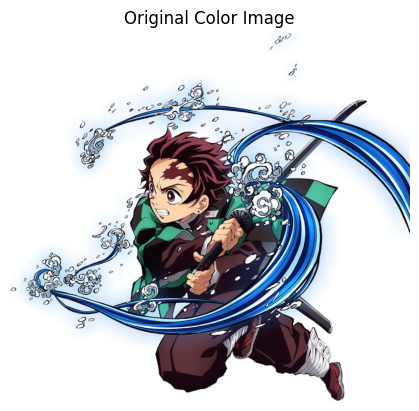

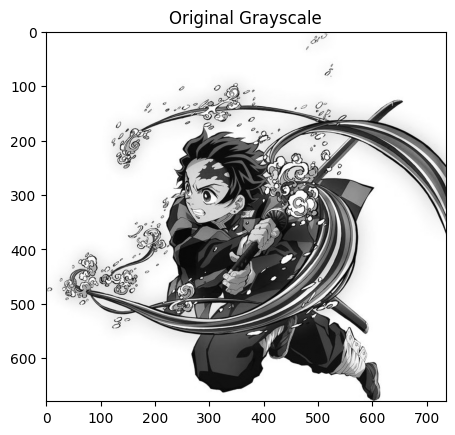

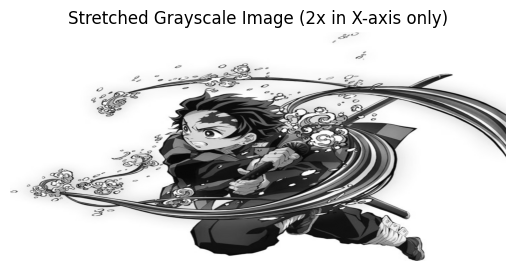

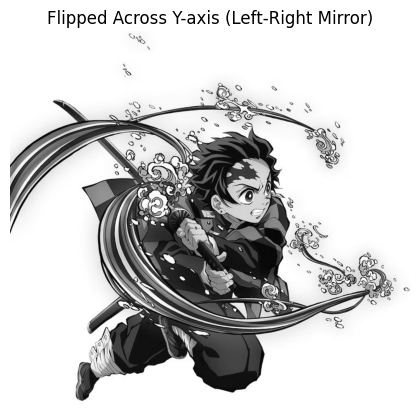

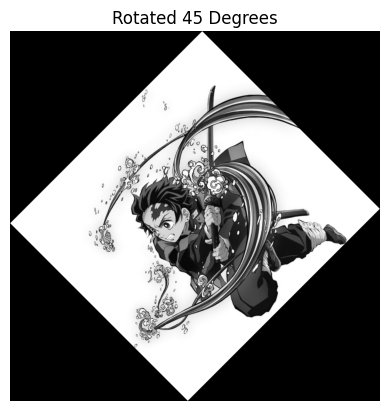

Original image shape: (680, 735)
Stretched image shape: (680, 1470)
Flipped image shape: (680, 735)
Rotated image shape: (1001, 1001)
Image data type: uint8
Image value range: [0, 255]
Red channel - U: (680, 680), S: (680,), Vt: (680, 735)
Green channel - U: (680, 680), S: (680,), Vt: (680, 735)
Red channel - U: (680, 680), S: (680,), Vt: (680, 735)
Green channel - U: (680, 680), S: (680,), Vt: (680, 735)
Blue channel - U: (680, 680), S: (680,), Vt: (680, 735)
Blue channel - U: (680, 680), S: (680,), Vt: (680, 735)


In [19]:

# Load the color image
A = imread('/app/sreeram/datascience/tangiro.jpg')


plt.figure()
plt.title('Original Color Image')
plt.imshow(A)
plt.axis('off')
plt.show()


A_gs = np.mean(A, -1)  # Convert to grayscale by averaging color channels
img = plt.imshow(A_gs, cmap='gray') 
plt.title('Original Grayscale')
plt.show()

# Stretch the grayscale image by a factor of 2 only in the x-axis (width)
# zoom takes (y_factor, x_factor) for 2D arrays
A_gs_stretched_x = zoom(A_gs, (1, 2), order=1)
plt.figure()
plt.title('Stretched Grayscale Image (2x in X-axis only)')
plt.imshow(A_gs_stretched_x, cmap='gray')
plt.axis('off')
plt.show()

# Flip/invert across the y-axis (horizontal flip, mirror left-right)
A_gs_flipped_y = np.fliplr(A_gs)
plt.figure()
plt.title('Flipped Across Y-axis (Left-Right Mirror)')
plt.imshow(A_gs_flipped_y, cmap='gray')
plt.axis('off')
plt.show()

# Rotate the grayscale image by 45 degrees
from scipy.ndimage import rotate
A_gs_rotated = rotate(A_gs, 45, reshape=True, order=1)
plt.figure()
plt.title('Rotated 45 Degrees')
plt.imshow(A_gs_rotated, cmap='gray')
plt.axis('off')
plt.show()

print(f'Original image shape: {A_gs.shape}')
print(f'Stretched image shape: {A_gs_stretched_x.shape}')
print(f'Flipped image shape: {A_gs_flipped_y.shape}')
print(f'Rotated image shape: {A_gs_rotated.shape}')

print(f'Image data type: {A.dtype}')
print(f'Image value range: [{A.min()}, {A.max()}]')

# Normalize image to [0, 1] if needed
if A.max() > 1:
    A = A / 255.0

# Apply SVD to each color channel separately
U_channels = []
S_channels = []
Vt_channels = []

for i, color in enumerate(['Red', 'Green', 'Blue']):
    U_c, S_c, Vt_c = np.linalg.svd(A[:, :, i], full_matrices=False)
    U_channels.append(U_c)
    S_channels.append(S_c)
    Vt_channels.append(Vt_c)
    print(f'{color} channel - U: {U_c.shape}, S: {S_c.shape}, Vt: {Vt_c.shape}')

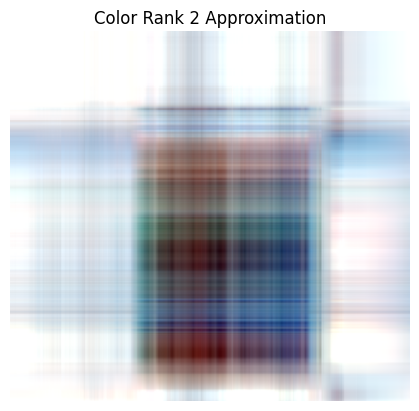

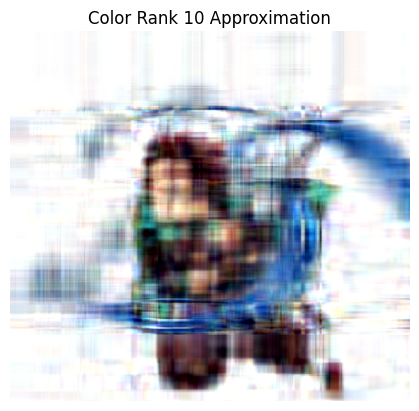

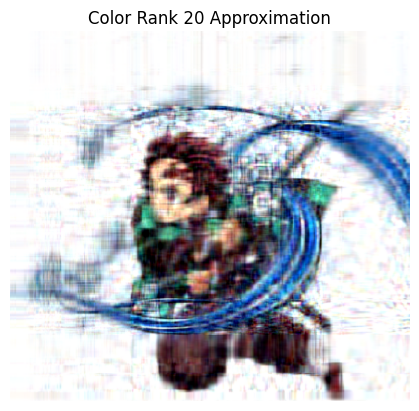

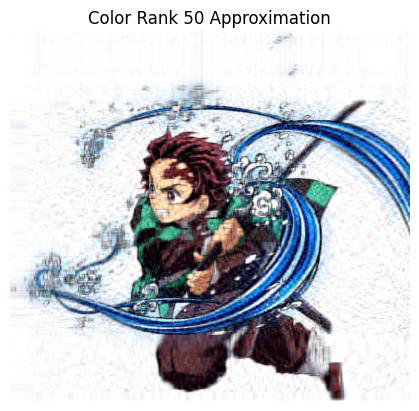

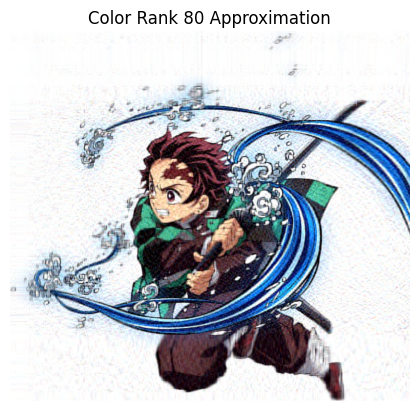

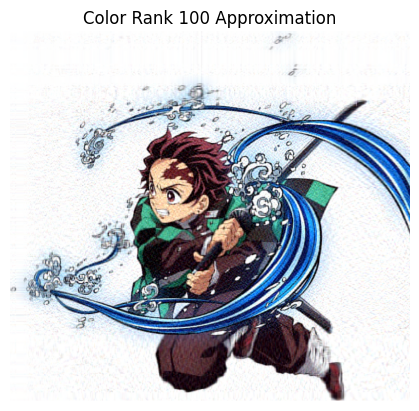

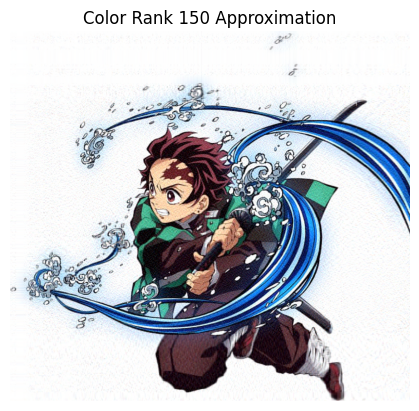

In [20]:
# Reconstruct color images at different ranks
ranks = [2, 10, 20, 50, 80, 100, 150]

for r in ranks:
    # Reconstruct each channel
    reconstructed = np.zeros_like(A)
    for i in range(3):
        S_diag = np.diag(S_channels[i])
        # We reconstruct the channel using the first r singular values/vectors
        reconstructed[:, :, i] = U_channels[i][:, :r] @ S_diag[:r, :r] @ Vt_channels[i][:r, :]
    
    # Clip values to valid range [0, 1]
    # SVD reconstruction produces values that may be slightly out of bounds. 
    # this is due to floating point arithmetic errors. So we clip them.
    reconstructed = np.clip(reconstructed, 0, 1)
    
    plt.figure()
    plt.title(f'Color Rank {r} Approximation')
    plt.imshow(reconstructed)
    plt.axis('off')
    plt.show()

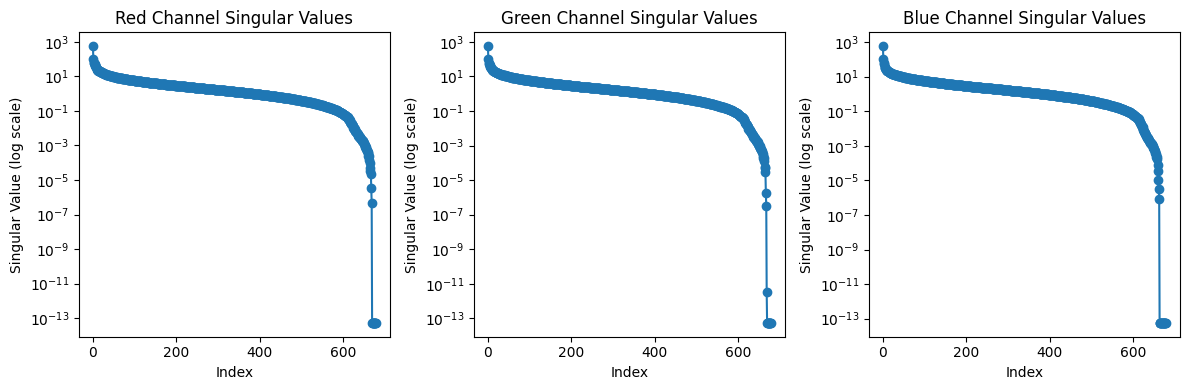

In [21]:
# Plot singular values for each channel
plt.figure(figsize=(12, 4))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    plt.subplot(1, 3, i+1)
    plt.semilogy(S_channels[i], '-o')
    plt.title(f'{color} Channel Singular Values')
    plt.xlabel('Index')
    plt.ylabel('Singular Value (log scale)')
plt.tight_layout()
plt.show()

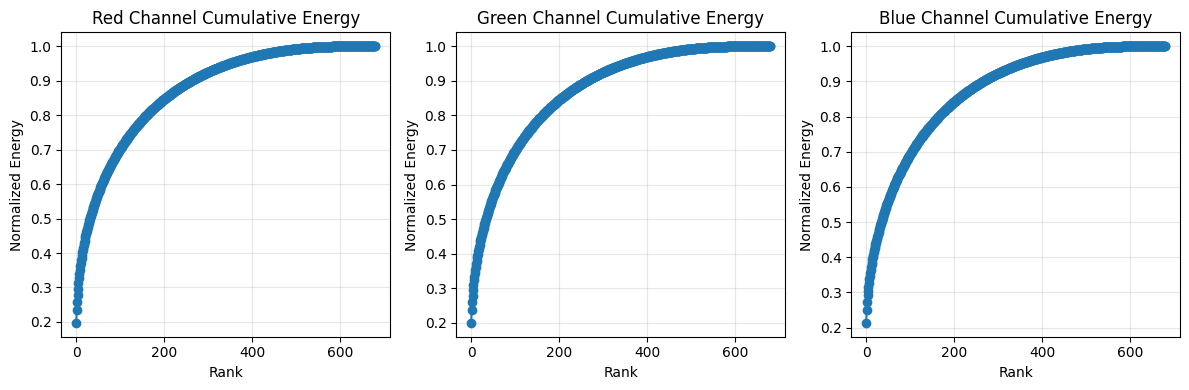

In [22]:
# Plot cumulative energy for each channel
plt.figure(figsize=(12, 4))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    plt.subplot(1, 3, i+1)
    cumsum = np.cumsum(S_channels[i]) / np.sum(S_channels[i])
    plt.plot(cumsum, 'o-')
    plt.title(f'{color} Channel Cumulative Energy')
    plt.xlabel('Rank')
    plt.ylabel('Normalized Energy')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Demonstrate the 45-degree rotation matrix
import math

theta = math.radians(45)  # Convert 45 degrees to radians
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

print("Rotation matrix R(45°):")
print(R)
print(f"\nExact values: sqrt(2)/2 = {np.sqrt(2)/2}")

# Example: Rotate a few test vectors
test_vectors = np.array([
    [1, 0],   # Unit vector along x-axis
    [0, 1],   # Unit vector along y-axis
    [1, 1],   # Diagonal vector
])

print("\nRotating test vectors by 45°:")
for i, vec in enumerate(test_vectors):
    rotated = R @ vec
    print(f"Vector {vec} -> {rotated}")
    print(f"  Original angle: {np.arctan2(vec[1], vec[0]) * 180/np.pi:.1f}°")
    print(f"  Rotated angle: {np.arctan2(rotated[1], rotated[0]) * 180/np.pi:.1f}°")

# Important note about applying to images
print("\n" + "="*60)
print("IMPORTANT: To rotate an entire image matrix A:")
print("You cannot simply do R @ A, because:")
print(f"  - R is 2×2")
print(f"  - A is {A_gs.shape[0]}×{A_gs.shape[1]}")
print("Image rotation requires applying R to each pixel's COORDINATES,")
print("then interpolating pixel values - that's what scipy.ndimage.rotate does.")
print("="*60)

Rotation matrix R(45°):
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

Exact values: sqrt(2)/2 = 0.7071067811865476

Rotating test vectors by 45°:
Vector [1 0] -> [0.70710678 0.70710678]
  Original angle: 0.0°
  Rotated angle: 45.0°
Vector [0 1] -> [-0.70710678  0.70710678]
  Original angle: 90.0°
  Rotated angle: 135.0°
Vector [1 1] -> [1.11022302e-16 1.41421356e+00]
  Original angle: 45.0°
  Rotated angle: 90.0°

IMPORTANT: To rotate an entire image matrix A:
You cannot simply do R @ A, because:
  - R is 2×2
  - A is 680×735
Image rotation requires applying R to each pixel's COORDINATES,
then interpolating pixel values - that's what scipy.ndimage.rotate does.


# Rotation Matrix Derivation

For a 2D rotation by angle θ (counter-clockwise), the rotation matrix is:

$$R(\theta) = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$$

For **θ = 45° = π/4 radians**:
- $\cos(45°) = \frac{\sqrt{2}}{2} \approx 0.707$
- $\sin(45°) = \frac{\sqrt{2}}{2} \approx 0.707$

Therefore:

$$R(45°) = \begin{bmatrix} \frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} \\ \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} \end{bmatrix} \approx \begin{bmatrix} 0.707 & -0.707 \\ 0.707 & 0.707 \end{bmatrix}$$

This rotates a 2D vector:
$$\begin{bmatrix} x' \\ y' \end{bmatrix} = R(45°) \begin{bmatrix} x \\ y \end{bmatrix}$$

**Note:** This operates on individual 2D coordinate vectors, not on the image matrix A directly. Image rotation requires applying this transformation to each pixel's spatial coordinates and then interpolating.

Original image shape: (680, 735)
Rotation matrix shape: (2, 2)

ATTEMPTING DIFFERENT MATRIX MULTIPLICATIONS:

1. R @ A_gs: FAILED - matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 680 is different from 2)
2. A_gs @ R: FAILED - matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 735)

3. Taking 2xN subimage: shape (2, 100)
   Each column is a 2D vector we can rotate
   R @ A_small: shape (2, 100)


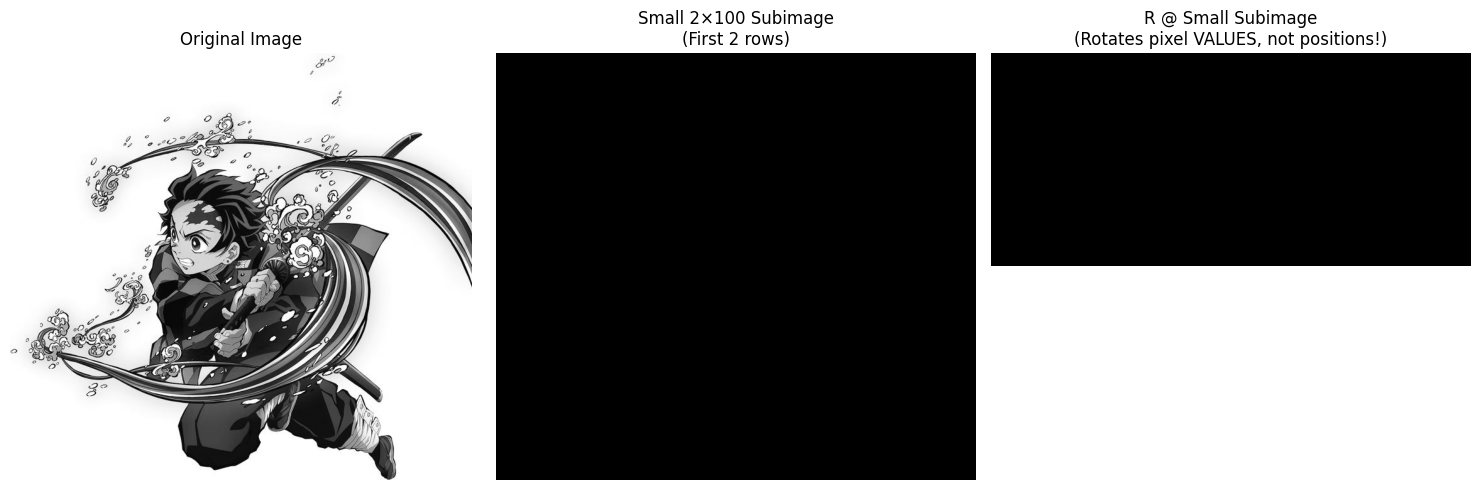


EXPLANATION:
The matrix multiplication R @ A_small treats each COLUMN as a 2D vector
and rotates the PIXEL VALUES, not the spatial positions.
This is NOT geometric image rotation!

For actual image rotation, use scipy.ndimage.rotate which:
  1. Applies R to pixel COORDINATES (x,y positions)
  2. Interpolates pixel values at the new positions


In [24]:
# Attempt to apply rotation matrix directly to image matrix
# WARNING: This won't work correctly for geometric rotation!

print("Original image shape:", A_gs.shape)
print("Rotation matrix shape:", R.shape)

# Try different matrix multiplications
print("\n" + "="*60)
print("ATTEMPTING DIFFERENT MATRIX MULTIPLICATIONS:")
print("="*60)

# Attempt 1: R @ A_gs (won't work - dimension mismatch)
try:
    result1 = R @ A_gs
    print(f"\n1. R @ A_gs: SUCCESS - shape {result1.shape}")
except Exception as e:
    print(f"\n1. R @ A_gs: FAILED - {e}")

# Attempt 2: A_gs @ R (won't work - dimension mismatch)
try:
    result2 = A_gs @ R
    print(f"2. A_gs @ R: SUCCESS - shape {result2.shape}")
except Exception as e:
    print(f"2. A_gs @ R: FAILED - {e}")

# Attempt 3: Treat each column as a 2D vector and rotate (mathematically valid but meaningless for images)
# Take a small 2xN subimage to demonstrate
A_small = A_gs[:2, :100]  # Take first 2 rows, 100 columns
print(f"\n3. Taking 2xN subimage: shape {A_small.shape}")
print("   Each column is a 2D vector we can rotate")

rotated_small = R @ A_small
print(f"   R @ A_small: shape {rotated_small.shape}")

# Visualize what this does
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(A_gs, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(A_small, cmap='gray', aspect='auto')
axes[1].set_title(f'Small 2×100 Subimage\n(First 2 rows)')
axes[1].axis('off')

axes[2].imshow(rotated_small, cmap='gray', aspect='auto')
axes[2].set_title(f'R @ Small Subimage\n(Rotates pixel VALUES, not positions!)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("EXPLANATION:")
print("="*60)
print("The matrix multiplication R @ A_small treats each COLUMN as a 2D vector")
print("and rotates the PIXEL VALUES, not the spatial positions.")
print("This is NOT geometric image rotation!")
print("\nFor actual image rotation, use scipy.ndimage.rotate which:")
print("  1. Applies R to pixel COORDINATES (x,y positions)")
print("  2. Interpolates pixel values at the new positions")
print("="*60)

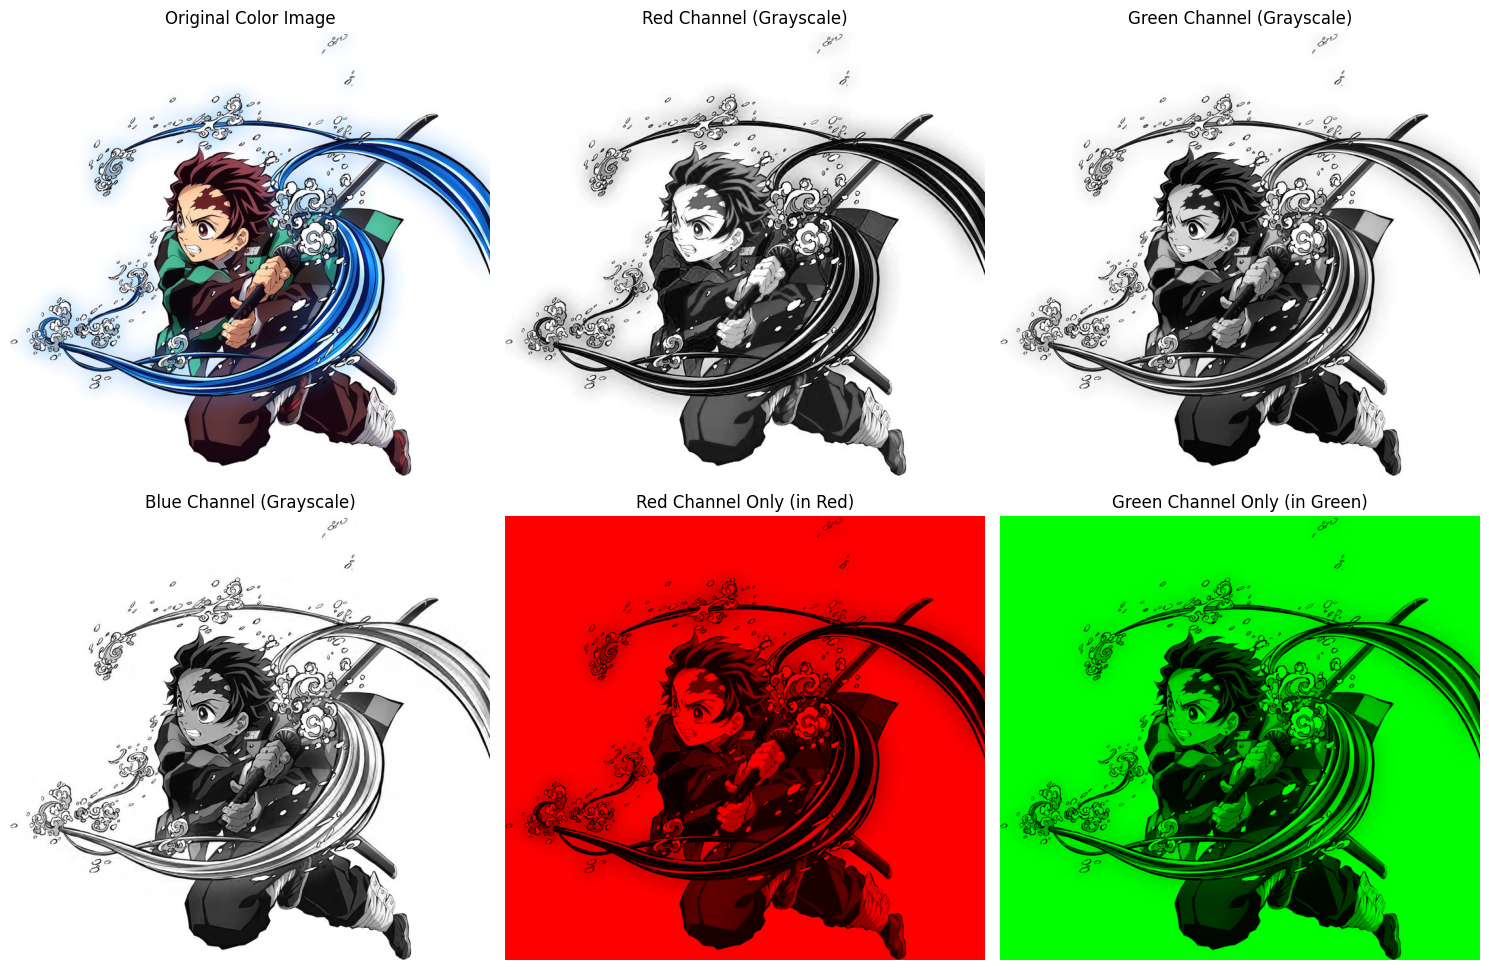

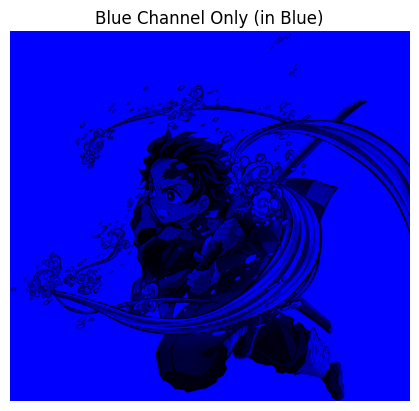

Image shape: (680, 735, 3)
Red channel range: [0, 255]
Green channel range: [0, 255]
Blue channel range: [0, 255]


In [27]:
# Display individual color channels
# Load original color image (not normalized)
A_color = imread('/app/sreeram/datascience/tangiro.jpg')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(A_color)
axes[0, 0].set_title('Original Color Image')
axes[0, 0].axis('off')

# Red channel only (shown in grayscale)
axes[0, 1].imshow(A_color[:, :, 0], cmap='gray')
axes[0, 1].set_title('Red Channel (Grayscale)')
axes[0, 1].axis('off')

# Green channel only (shown in grayscale)
axes[0, 2].imshow(A_color[:, :, 1], cmap='gray')
axes[0, 2].set_title('Green Channel (Grayscale)')
axes[0, 2].axis('off')

# Blue channel only (shown in grayscale)
axes[1, 0].imshow(A_color[:, :, 2], cmap='gray')
axes[1, 0].set_title('Blue Channel (Grayscale)')
axes[1, 0].axis('off')

# Red channel displayed in red color
red_only = np.zeros_like(A_color)
red_only[:, :, 0] = A_color[:, :, 0]
axes[1, 1].imshow(red_only)
axes[1, 1].set_title('Red Channel Only (in Red)')
axes[1, 1].axis('off')

# Green channel displayed in green color
green_only = np.zeros_like(A_color)
green_only[:, :, 1] = A_color[:, :, 1]
axes[1, 2].imshow(green_only)
axes[1, 2].set_title('Green Channel Only (in Green)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Blue channel displayed in blue color (separate figure)
plt.figure()
blue_only = np.zeros_like(A_color)
blue_only[:, :, 2] = A_color[:, :, 2]
plt.imshow(blue_only)
plt.title('Blue Channel Only (in Blue)')
plt.axis('off')
plt.show()

print(f"Image shape: {A_color.shape}")
print(f"Red channel range: [{A_color[:,:,0].min()}, {A_color[:,:,0].max()}]")
print(f"Green channel range: [{A_color[:,:,1].min()}, {A_color[:,:,1].max()}]")
print(f"Blue channel range: [{A_color[:,:,2].min()}, {A_color[:,:,2].max()}]")